In [1]:
#pip install -r requirements.txt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

df = pd.read_csv("data/data.csv")

In [3]:
missing = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"Number of missing rows: {missing}\nNumber of duplicate rows: {duplicates}")

Number of missing rows: 0
Number of duplicate rows: 0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
#audio feature analysis

#define audio features: 
audio_features = ['valence', 'acousticness', 'danceability', 'energy', 
                  'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
af = df[audio_features]
print("Audio Features Statistics:")
af[audio_features].describe().T


Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
valence,170653.0,0.528587,0.263171,0.0,0.3170,0.540000,0.7470,1.000
acousticness,170653.0,0.502115,0.376032,0.0,0.1020,0.516000,0.8930,0.996
danceability,170653.0,0.537396,0.176138,0.0,0.4150,0.548000,0.6680,0.988
energy,170653.0,0.482389,0.267646,0.0,0.2550,0.471000,0.7030,1.000
instrumentalness,170653.0,0.167010,0.313475,0.0,0.0000,0.000216,0.1020,1.000
liveness,170653.0,0.205839,0.174805,0.0,0.0988,0.136000,0.2610,1.000
loudness,170653.0,-11.467990,5.697943,-60.0,-14.6150,-10.580000,-7.1830,3.855
speechiness,170653.0,0.098393,0.162740,0.0,0.0349,0.045000,0.0756,0.970
tempo,170653.0,116.861590,30.708533,0.0,93.4210,114.729000,135.5370,243.507


In [6]:
#dropping rows with tempo=0 
af = af[af['tempo'] != 0]
af[audio_features].describe().T

,count,mean,std,min,25%,50%,75%,max
valence,170510.0,0.529031,0.262836,0.00000,0.3180,0.540000,0.74700,1.000
acousticness,170510.0,0.502066,0.376000,0.00000,0.1020,0.516000,0.89300,0.996
danceability,170510.0,0.537846,0.175522,0.05510,0.4160,0.548000,0.66800,0.988
energy,170510.0,0.482637,0.267513,0.00002,0.2550,0.471000,0.70300,1.000
instrumentalness,170510.0,0.166746,0.313242,0.00000,0.0000,0.000215,0.10100,1.000
liveness,170510.0,0.205753,0.174681,0.00967,0.0987,0.136000,0.26100,1.000
loudness,170510.0,-11.458655,5.677952,-55.00000,-14.6050,-10.575000,-7.18100,3.744
speechiness,170510.0,0.098476,0.162783,0.02220,0.0350,0.045000,0.07570,0.970
tempo,170510.0,116.959597,30.534275,30.94600,93.4860,114.766000,135.56575,243.507


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
af_scaled_np = scaler.fit_transform(af)
af_scaled = pd.DataFrame(af_scaled_np, columns=af.columns, index=af.index)
af_scaled

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,-1.786787,1.276424,-1.474723,-1.015420,2.270628,2.629064,-1.521212,-0.380112,-1.179190
1,1.651108,0.611529,1.601816,-0.529460,-0.532325,-0.261925,-0.173011,1.944457,-1.834783
2,-1.862880,1.220573,-1.195556,-1.183636,2.382363,-0.599684,-0.597285,-0.396699,-0.216826
3,-1.385014,1.236531,-1.497512,-0.649081,-0.532237,1.003241,0.377365,-0.387484,-0.551860
4,-1.050204,1.209935,-0.682799,-1.082706,-0.532320,0.133082,0.239991,-0.371512,-0.500901
...,...,...,...,...,...,...,...,...,...
170648,0.300452,-1.110284,1.413805,1.216255,-0.531403,-0.707308,1.366105,-0.063740,-0.390729
170649,0.779840,-0.787411,1.020692,1.010657,-0.532325,-0.599684,0.957858,-0.233291,0.686981
170650,0.410788,-1.066667,0.547816,1.403163,-0.532298,0.299099,1.626058,-0.107971,-0.827649
170651,-1.270874,-1.308742,0.758616,0.524698,-0.532301,2.503120,0.756904,1.287139,-1.372383


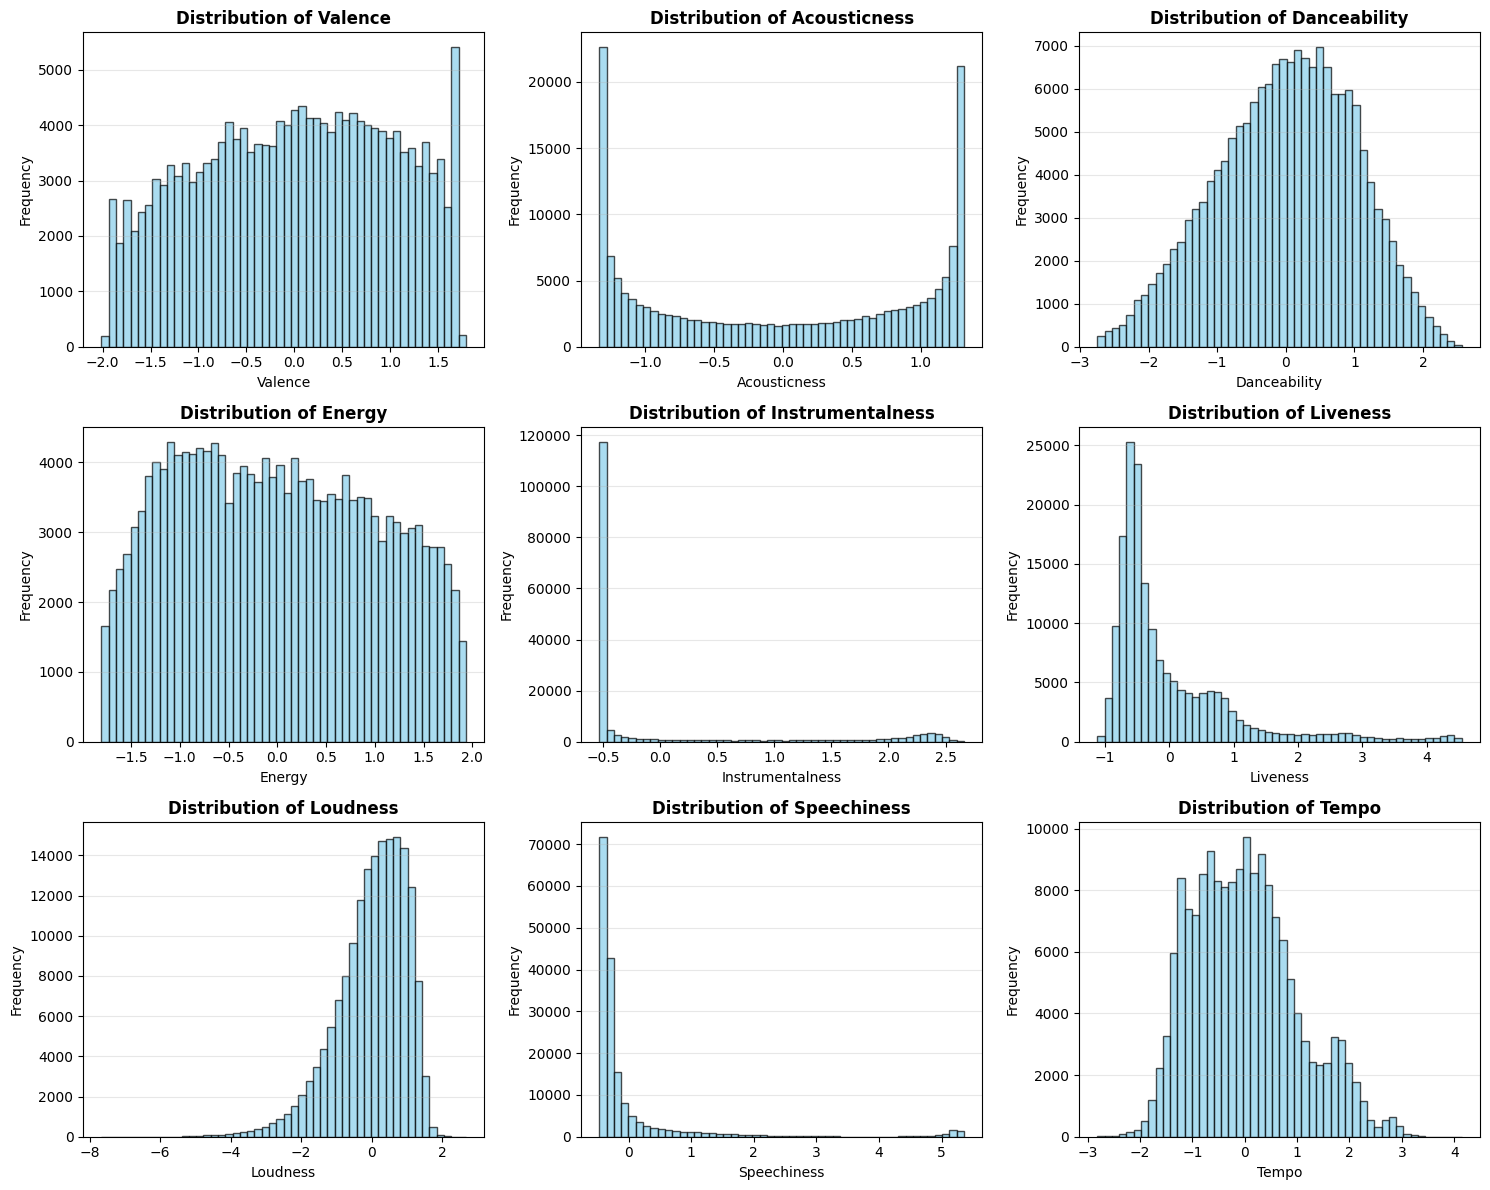

In [8]:
# Plot distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(af_scaled[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

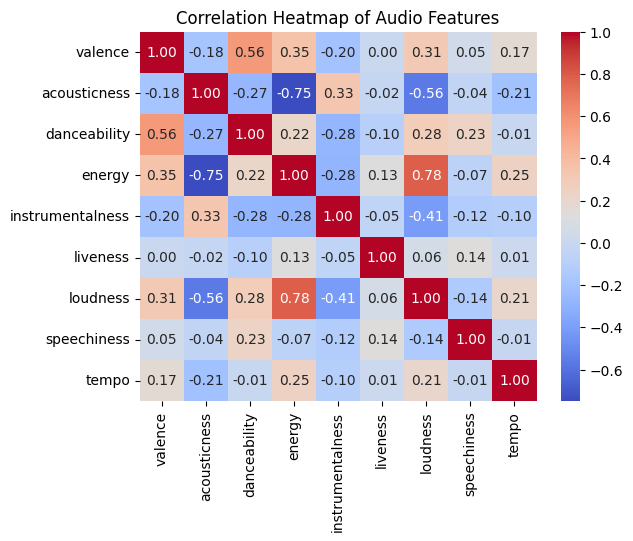

In [9]:
import seaborn as sns

plt.figure()
correlation_matrix = af_scaled[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

In [10]:
print(" Strong Correlations (|r| > 0.5):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            strong_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

pd.DataFrame(strong_corr).sort_values('Correlation', ascending=False)

 Strong Correlations (|r| > 0.5):


,Feature 1,Feature 2,Correlation
3,energy,loudness,0.783643
0,valence,danceability,0.556925
2,acousticness,loudness,-0.564138
1,acousticness,energy,-0.750396


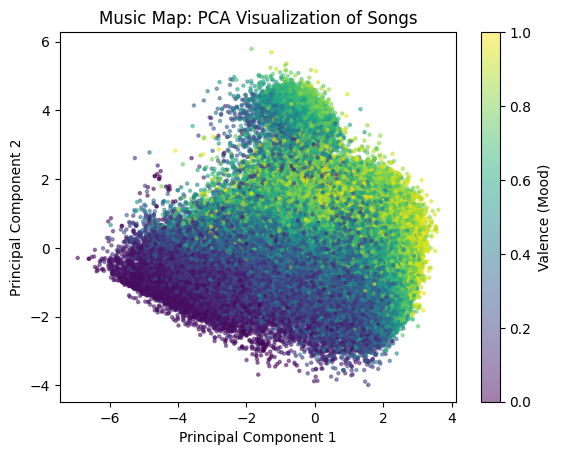

In [11]:
# 1. PCA 모델 생성 (2차원으로 축소)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(af_scaled)

# 2. 시각화 (Scatter Plot)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=af['valence'], cmap='viridis', s=5, alpha=0.5)
plt.colorbar(label='Valence (Mood)')
plt.title("Music Map: PCA Visualization of Songs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 설명: 점 하나가 노래 한 곡입니다.
# 색깔(Valence)은 노래의 밝기(Mood)를 나타냅니다.
# 비슷한 색깔끼리 뭉쳐 있다면, 특징별로 잘 정렬된 것입니다.

Testing different numbers of clusters:
k=2: Inertia=1166295.29, Silhouette=0.240
k=3: Inertia=1013637.91, Silhouette=0.258
k=4: Inertia=898396.10, Silhouette=0.215
k=5: Inertia=811102.82, Silhouette=0.188
k=6: Inertia=737043.69, Silhouette=0.198
k=7: Inertia=683268.57, Silhouette=0.181
k=8: Inertia=644012.74, Silhouette=0.184
k=9: Inertia=609998.46, Silhouette=0.183
k=10: Inertia=586063.70, Silhouette=0.178


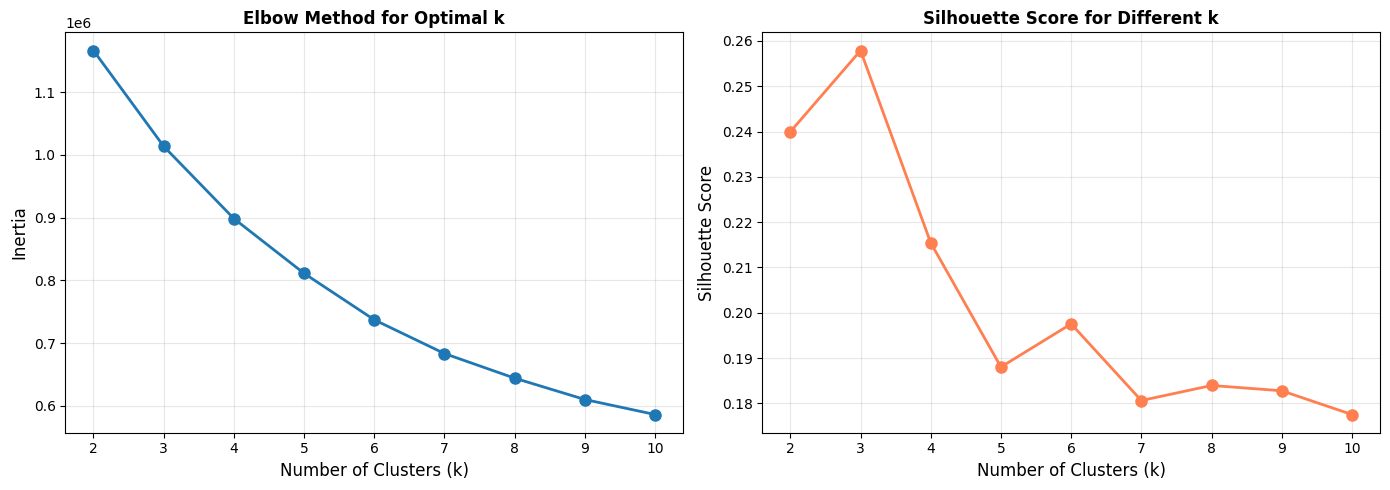


✅ Clustering analysis completed!


In [12]:
# Clustering analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # ✅ 2~10으로 줄임

print("Testing different numbers of clusters:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(af_scaled_np)  # ✅ numpy array 사용
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on a sample for speed)
    sample_size = min(10000, len(af_scaled_np))  # ✅ 통일
    sample_idx = np.random.choice(len(af_scaled_np), sample_size, replace=False)
    silhouette = silhouette_score(af_scaled_np[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Clustering analysis completed!")